In [1]:
%matplotlib inline
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model as sklm
import sklearn.model_selection as skcv
import ml_uncertainty as plu

In [2]:
xdata = np.array([[4.00],
[4.20],
[4.30],
[4.47],
[4.58],
[4.60],
[4.61],
[4.82],
[5.05],
[5.24],
[5.43],
[5.58],
[5.82],
[5.91],
[5.92],
[6.03],
[6.32],
[6.45],
[6.67],
[6.68],
[6.91],
[7.04],
[7.09],
[7.35],
[7.49],
[7.62],
[7.81],
[7.94]])

#Create the linear regression X matrix
xmatrix_first = np.ones_like(xdata) #Constant term
xmatrix_last = xdata**2 #Square term
#Add in the linear term
xmatrix = np.concatenate((xmatrix_first,xdata,xmatrix_last),axis=1) 

In [3]:
yfull = np.array([[3.70,3.53,4.12,5.03,],
[2.96,4.69,6.44,7.36,],
[4.69,3.68,5.86,5.70,],
[4.28,4.22,5.32,6.33,],
[4.86,5.27,5.61,5.57,],
[4.77,4.61,5.38,4.91,],
[4.74,4.45,6.34,5.71,],
[4.76,4.40,6.51,5.62,],
[5.01,5.52,5.85,6.92,],
[5.59,5.81,5.86,7.98,],
[5.17,4.67,5.58,8.38,],
[6.02,6.04,5.70,6.87,],
[6.68,5.94,5.78,8.10,],
[6.91,5.97,5.68,7.80,],
[6.14,5.74,6.30,7.65,],
[5.67,5.78,4.97,8.98,],
[6.89,6.41,6.40,8.08,],
[6.57,6.46,6.44,8.43,],
[7.34,6.31,6.14,8.55,],
[6.62,5.98,5.78,9.17,],
[7.22,6.59,5.99,8.95,],
[8.05,6.85,6.78,10.92,],
[7.11,7.29,6.19,9.74,],
[6.43,7.40,6.45,9.39,],
[7.02,7.14,7.34,10.13,],
[7.27,7.37,6.12,10.04,],
[7.29,7.07,5.65,10.91,],
[8.29,8.39,6.57,11.78,]])

ydata = yfull[:,0]

#Make the data into a 2nd-order monomial with 2x the residual
# of the linear data
resid = ydata-np.squeeze(xdata)
ysquared = np.squeeze(xdata**2) + 2*resid 

In [4]:
linear_regressor = sklm.LinearRegression
regr = linear_regressor()
cv = skcv.KFold(n_splits=6,shuffle=True)

$$Y = X\beta$$
$$\beta = (X^TX)^{-1}X^TY$$

In [5]:
regr.fit(xmatrix[:,1:],ysquared)
ypred = regr.predict(xmatrix[:,1:])
y_cv = skcv.cross_val_predict(regr,xmatrix[:,1:],y=ysquared,cv=cv)


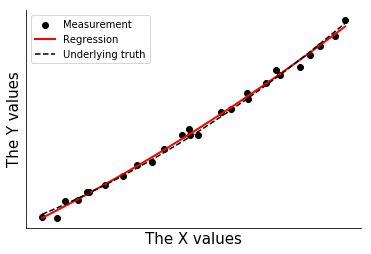

In [7]:
#with plt.xkcd():
fig,ax = plt.subplots(1,1)

p1 = plt.scatter(xdata,ysquared,color='k',label='Measurement')
p2 = plt.plot(xdata,ypred,color='r',lw=2,label='Regression')
p3 = plt.plot(xdata,xdata**2,color='k',ls='--',label='Underlying truth')

handles, labels = ax.get_legend_handles_labels()

plt.legend([handles[i] for i in [2,0,1]],[labels[i] for i in [2,0,1]])
ax.set_xlabel('The X values',size=15)
ax.set_ylabel('The Y values',size=15)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel

t = 1

$$ Y_{new} = X_{new}\beta + \epsilon$$

$$ \delta Y_{new} = t(0.95,n-2)\Bigg\{
                          \frac{Y^TY-\beta^TX^TY}{n-2}\Bigg[X_{new}(X^TX)^{-1}X_{new}^T+1\Bigg]
                          \Bigg\}^{1/2}$$

In [25]:
#Create the linear regression X matrix
#xmatrix_first = np.ones_like(xdata) #Constant term
#xmatrix = np.concatenate((xmatrix_first,xdata),axis=1) #Add in the linear term

cov = np.dot(xmatrix.T,xmatrix) #Covariance matrix
icov = np.linalg.inv(cov) #Inverse covariance matrix
xty = np.dot(xmatrix.T,ysquared[:,np.newaxis,]) #XTy

beta = np.dot(icov,xty) #Coefficients

nvars = xmatrix.shape[1]
nsamp = xmatrix.shape[0]

dof = nsamp - nvars#Degrees of freedom
tdist = sp.stats.t(dof) #T distribution
#T premultiplier, only one standard deviation because n is large. Squared because of how pred_unc is defined below
tmult = tdist.ppf(0.95) ** 2 

sse = (np.dot(ysquared.T,ysquared) - np.dot(ypred.T,ysquared))/(dof) #mean squared error

var_premult = tmult * sse 

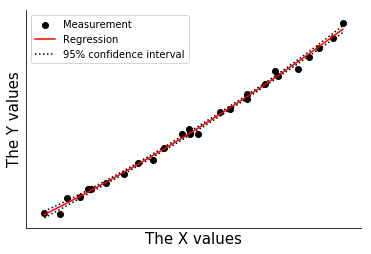

In [11]:
yl = []
yu = []
for row in xmatrix:

    yp = np.dot(row,beta)
    pred_unc = np.sqrt(var_premult*(np.dot(np.dot(row,icov),row.T)))

    yl += [yp - 1*pred_unc]
    yu += [yp + 1*pred_unc]

    #print(pred)

    #print(pred,pred_lower,pred_upper)
lower = np.concatenate(yl)
upper = np.concatenate(yu)

yunc = np.concatenate((yl,yu),axis=1)

fig,ax = plt.subplots()

ax.plot(xdata,ypred,color='r',label='Regression')
ax.plot(xdata,yunc,ls=':',color='k',label='95% confidence interval')
ax.scatter(xdata,ysquared,color='k',label='Measurement')

handles, labels = ax.get_legend_handles_labels()

ax.legend([handles[i] for i in [3,0,1]],[labels[i] for i in [3,0,1]])

ax.set_xlabel('The X values',size=15)
ax.set_ylabel('The Y values',size=15)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.legend()

In [12]:
residual,err,mse = plu.get_residual_stats(ysquared,ypred)
residual_cv,err_cv,msecv = plu.get_residual_stats(ysquared,y_cv)

num_train = len(xdata)

pseudo_dof = num_train * (1 - np.sqrt(mse/msecv))
bootstrap_weight = np.sqrt(1 - pseudo_dof/num_train)

print(bootstrap_weight)

residual_weighted = residual / bootstrap_weight

0.9406480574386638


In [13]:
samples = 5

residual_boot,boot_indices = plu.bootstrap_data(residual_weighted,samples=samples)
residual_boot = np.squeeze(residual_boot)

boot_data = (residual_boot + ypred).T #boot_data now has the new Y values with shuffled residuals

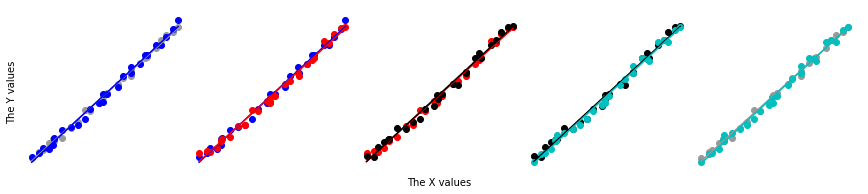

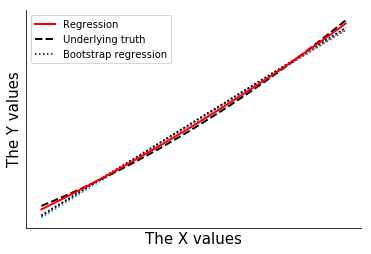

In [14]:
fig,axes = plt.subplots(1,samples,figsize=(3*samples,3),sharey=True,
                        gridspec_kw=dict(wspace=0),subplot_kw=dict(frameon=False))
fig2,ax2=plt.subplots(1,1)

colors = '0.6','b','r','k','c'
ax2.plot(xdata,ypred,color='r',lw=2,zorder=100,label='Regression')
ax2.plot(xdata,xdata**2,color='k',ls='--',lw=2,zorder=99,label='Underlying truth')

ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_xlabel('The X values',size=15)
ax2.set_ylabel('The Y values',size=15)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
axes[0].spines['left'].set_visible(True)

for plot_num,(color,yboot) in enumerate(zip(colors,boot_data.T)):
    
    yb = yboot[:,np.newaxis]
    
    #fig,ax = plt.subplots(1,1)
    regr.fit(xdata,yb)
    ypb = regr.predict(xdata)
    
    #print('{},{}'.format(plot_num-1,plot_num+1))
    
    for ax in axes[[plot_num-1,plot_num]]:
        ax.scatter(xdata,yb,color=color)
        ax.plot(xdata,ypb,color=color)
        ax.set_xticks([])
    if color=='k':
        ax2.plot(xdata,ypb,color=color,ls=':',label='Bootstrap regression')
    else:
        ax2.plot(xdata,ypb,color=color,ls=':')

ax = axes[0]
ax.set_yticks([])
ax.set_ylabel('The Y values')
ax = axes[2]
ax.set_xlabel('The X values')


ax2.legend()


In [15]:
samples = 1000

linear_bootstrap = plu.bootstrap_estimator(estimator=linear_regressor,
                                           X=xmatrix[:,1:],y=ysquared,samples=samples,cv=cv,
                                          )

linear_bootstrap.fit()

ypred,cpb,bounds,error, = linear_bootstrap.bootstrap_uncertainty_bounds()

#lbt_out = plu.bootstrap(xdata=xdata,ydata=np.squeeze(ydata),
#                        PLS_model=regr,cv_object=cv,samples=samples)
#rcv,ecv,msecv,cpb,cpt = lbt_out

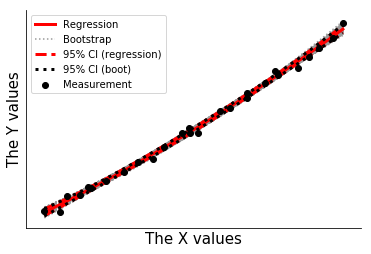

In [16]:
fig2,ax2=plt.subplots(1,1)

for ypb in cpb:
    ax2.plot(xdata,ypb,color='0.6',ls=':',zorder=0)

ax2.plot(xdata,ypred,color='r',lw=3,label='Regression',zorder=3)
ax2.plot(xdata,yunc,ls='--',color='r',lw=3,label='95% CI (regression)',zorder=3)
ax2.plot(xdata,ypb,color='0.6',ls=':',label='Bootstrap',zorder=-1)

ax2.plot(xdata,bounds.T,ls=':',color='k',lw=3,label='95% CI (boot)',zorder=4)

ax2.scatter(xdata,ysquared,color='k',label='Measurement',zorder=5)

ax2.set_xlabel('The X values',size=15)
ax2.set_ylabel('The Y values',size=15)

ax2.set_xticks([])
ax2.set_yticks([])


ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

#ax2.legend()

handles, labels = ax2.get_legend_handles_labels()

ax2.legend([handles[i] for i in [0,3,1,4,6]],[labels[i] for i in [0,3,1,4,6]])

t = 1

In [17]:
(yunc - bounds.T)/error.T

array([[ 0.09483087, -0.10595275],
       [ 0.10746581, -0.10633848],
       [ 0.10166273, -0.12672244],
       [ 0.08929502, -0.11990567],
       [ 0.12438105, -0.09780311],
       [ 0.1261887 , -0.09332473],
       [ 0.12626065, -0.0912731 ],
       [ 0.10391902, -0.10553357],
       [ 0.12381275, -0.14610142],
       [ 0.1451628 , -0.12070537],
       [ 0.16982132, -0.10073642],
       [ 0.18724042, -0.07826695],
       [ 0.19304763, -0.10100713],
       [ 0.16893004, -0.07911934],
       [ 0.16634934, -0.07878156],
       [ 0.14194964, -0.07905529],
       [ 0.16571014, -0.10854832],
       [ 0.16550811, -0.10531119],
       [ 0.15156991, -0.12251177],
       [ 0.14921162, -0.12882945],
       [ 0.16454438, -0.18028952],
       [ 0.16855882, -0.1692009 ],
       [ 0.15441342, -0.17368161],
       [ 0.13762857, -0.14694859],
       [ 0.12559564, -0.1587315 ],
       [ 0.10218068, -0.17468748],
       [ 0.11006489, -0.17726765],
       [ 0.11500796, -0.18186523]])

In [18]:
yunc

array([[14.27109377, 15.97394449],
       [16.37680081, 17.76217485],
       [17.43537962, 18.686175  ],
       [19.24163371, 20.30478879],
       [20.41382092, 21.38525244],
       [20.62718987, 21.58454258],
       [20.73390178, 21.68451633],
       [22.97968771, 23.83396889],
       [25.45728854, 26.29032594],
       [27.53107877, 28.38713721],
       [29.64108567, 30.5334338 ],
       [31.33772939, 32.25756711],
       [34.11528272, 35.06436097],
       [35.17772189, 36.13130615],
       [35.29648349, 36.25032982],
       [36.61228694, 37.56583283],
       [40.16305744, 41.08983596],
       [41.79175482, 42.69739948],
       [44.59475653, 45.46254661],
       [44.72342105, 45.58970988],
       [47.70695501, 48.55573803],
       [49.40911429, 50.27192671],
       [50.06582826, 50.94064503],
       [53.49222197, 54.50217208],
       [55.34336183, 56.48023124],
       [57.06665282, 58.35428906],
       [59.59531748, 61.15545813],
       [61.33396394, 63.11291955]])

In [19]:
bounds.T

array([[14.18157366, 16.07448446],
       [16.29375706, 17.84495417],
       [17.36485319, 18.77724574],
       [19.18972835, 20.37751209],
       [20.345278  , 21.43825215],
       [20.55910007, 21.63455203],
       [20.66618914, 21.73293219],
       [22.930696  , 23.88491853],
       [25.39865577, 26.36186427],
       [27.45871042, 28.44615106],
       [29.54993178, 30.5834779 ],
       [31.23250963, 32.29689087],
       [34.00278657, 35.11816107],
       [35.08238569, 36.17293874],
       [35.20275709, 36.29173306],
       [36.53421263, 37.60717462],
       [40.07044362, 41.14590933],
       [41.70143859, 42.75039947],
       [44.51842314, 45.52404836],
       [44.64837753, 45.65454068],
       [47.62405831, 48.64984816],
       [49.32231381, 50.36044898],
       [49.98640955, 51.03310856],
       [53.41225758, 54.58983612],
       [55.26336696, 56.58965504],
       [56.99503156, 58.49363263],
       [59.50055003, 61.32651216],
       [61.2181546 , 63.31027015]])

In [20]:
error.T

array([[0.94399751, 0.94891328],
       [0.77274589, 0.77845123],
       [0.69372945, 0.7186631 ],
       [0.58127947, 0.60650427],
       [0.551072  , 0.54190215],
       [0.53958709, 0.53586486],
       [0.53629251, 0.53045055],
       [0.47144125, 0.48278128],
       [0.47356007, 0.48964844],
       [0.49853236, 0.48890829],
       [0.53676354, 0.49678258],
       [0.56195001, 0.50243122],
       [0.58273782, 0.53263669],
       [0.56435315, 0.52619991],
       [0.56343114, 0.52554483],
       [0.55001416, 0.52294783],
       [0.55889049, 0.51657522],
       [0.54569065, 0.50327023],
       [0.50361838, 0.50200684],
       [0.50293351, 0.50322964],
       [0.50379542, 0.52199443],
       [0.51495664, 0.52317854],
       [0.51432522, 0.53237379],
       [0.58101593, 0.59656261],
       [0.63692399, 0.6893641 ],
       [0.70092757, 0.7976735 ],
       [0.86101429, 0.96494784],
       [1.00696801, 1.08514754]])

In [21]:
linear_bootstrap.boot_data.shape

(1000, 28)

In [22]:
linear_bootstrap.boot_data.std(axis=0)

array([0.98414377, 0.9800988 , 0.96281945, 0.97785665, 0.99255599,
       0.96224198, 0.97777613, 0.9784806 , 0.97131318, 0.99204086,
       0.99410038, 0.95844077, 0.99162786, 0.95797863, 0.97178914,
       0.95407061, 0.97049178, 0.97078983, 0.99070464, 0.96782657,
       0.98975311, 0.96187947, 0.96709553, 0.94918955, 0.96550174,
       1.00714298, 1.00930739, 1.0094565 ])

In [23]:
linear_bootstrap.base_predict(xmatrix[:,1:]).shape

(28,)

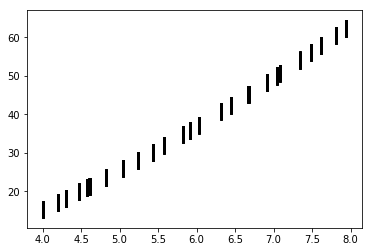

In [24]:
ymodel = linear_bootstrap.base_predict(xmatrix[:,1:])
for row in linear_bootstrap.boot_data:
    plt.scatter(xdata,row+ymodel,s=1,color='k')